In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, entropy, wasserstein_distance
from scipy.signal import unit_impulse
import ipywidgets as widgets
from ipywidgets import interact


#📏 KL, JS и Wasserstein — как отличить два распределения?

Когда у нас есть два распределения — например, **то, что мы сгенерировали** и **настоящее**, нужно понять, насколько они похожи.  
Для этого придумано много "мер различия". Мы рассмотрим три:

---

### 🔹 KL-дивергенция (Kullback–Leibler)

KL показывает, насколько распределение $Q$ отличается от $P$, если мы представим, что данные приходят из $P$.

Это можно понимать как "штраф" за то, что мы используем $Q$ вместо $P$.

$$
D_{KL}(P || Q) = \sum p(x) \log\left(\frac{p(x)}{q(x)}\right)
$$

- Если $P$ и $Q$ одинаковы → KL = 0
- Если $Q$ совсем не покрывает те места, где у $P$ есть масса → KL становится очень большим или бесконечным
- **KL несимметрична**: $D_{KL}(P || Q) \neq D_{KL}(Q || P)$

---

### 🔸 JS-дивергенция (Jensen–Shannon)

JS — это "усреднённая и симметричная" версия KL. Она сравнивает каждое распределение с их "средним":

$$
D_{JS}(P || Q) = \frac{1}{2} D_{KL}(P || M) + \frac{1}{2} D_{KL}(Q || M), \quad M = \frac{1}{2}(P + Q)
$$

- JS симметрична: $D_{JS}(P || Q) = D_{JS}(Q || P)$
- Никогда не бывает бесконечной, максимум — $\log 2 \approx 0.693$

---

### 🔹 Wasserstein (Earth Mover's Distance)

Эта метрика показывает, сколько "работы" нужно, чтобы "перенести массу" из одного распределения грязи или земли в другое.

Представьте два холма из песка. Wasserstein говорит, насколько далеко надо перетаскивать песок, чтобы один холм стал другим.

- Если холмы совпадают → расстояние маленькое
- Если холмы разной формы → расстояние большое
- Гладкая и стабильная метрика, даже если распределения не пересекаются

Давайте посмотрим на конкретных примерах на поведение значений этих величин при различных формат распределений.



In [ ]:
# JS-дивергенция
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * entropy(p + 1e-12, m + 1e-12) + 0.5 * entropy(q + 1e-12, m + 1e-12)

# Визуализация и измерения
def plot_and_measure(mu1, sigma1, mu2, sigma2):
    x = np.linspace(-10, 10, 1000)

    # Плотности
    p = norm.pdf(x, mu1, sigma1)
    q = norm.pdf(x, mu2, sigma2)

    # Метрики
    kl = entropy(p + 1e-12, q + 1e-12)
    js = js_divergence(p, q)
    wd = wasserstein_distance(x, x, p, q)

    # Область перекрытия
    intersection = np.minimum(p, q)

    # График
    plt.figure(figsize=(6, 3))
    plt.plot(x, p, label=f'P = N({mu1},{sigma1})')
    plt.plot(x, q, label=f'Q = N({mu2},{sigma2})', linestyle='--')
    plt.fill_between(x, intersection, alpha=0.3, label='Overlap')
    plt.title(f"KL={kl:.3f}, JS={js:.3f}, WD={wd:.3f}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Интерактив
@interact(
    mu1=widgets.FloatSlider(value=-2, min=-10, max=10, step=0.1, description='μ₁'),
    sigma1=widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description='σ₁'),
    mu2=widgets.FloatSlider(value=2, min=-10, max=10, step=0.1, description='μ₂'),
    sigma2=widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description='σ₂'),
)
def interactive_plot(mu1, sigma1, mu2, sigma2):
    plot_and_measure(mu1, sigma1, mu2, sigma2)



- KL резко возрастает, если P и Q почти не пересекаются.
- JS ограничена сверху значением \( \log 2 \approx 0.693 \).
- Wasserstein стабильно отражает расстояние между центрами масс.

**Область перекрытия** визуализирована заливкой.


In [ ]:
# JS для one-hot векторов
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * entropy(p + 1e-12, m + 1e-12) + 0.5 * entropy(q + 1e-12, m + 1e-12)

# KL-дивергенция
def kl_divergence(p, q):
    return entropy(p + 1e-12, q + 1e-12)

# Отрисовка
def plot_impulse_divergences(n, pos_p, pos_q):
    p = unit_impulse(n, idx=pos_p)
    q = unit_impulse(n, idx=pos_q)

    kl = kl_divergence(p, q)
    js = js_divergence(p, q)
    wd = wasserstein_distance([pos_p], [pos_q])

    plt.figure(figsize=(6, 3))
    plt.vlines(np.arange(n), 0, p, colors='red', label='P (red)', linewidth=4)
    plt.vlines(np.arange(n), 0, q, colors='green', label='Q (green)', linestyle='dashed', linewidth=2)
    plt.title(f"Impulse P: {pos_p}, Q: {pos_q}\nKL: {kl:.2f}, JS: {js:.3f}, WD: {wd:.2f}")
    plt.ylim(0, 1.2)
    plt.xticks(np.arange(n))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Интерактив
@interact(
    n=widgets.IntSlider(value=20, min=5, max=50, step=1, description='Length'),
    pos_p=widgets.IntSlider(value=5, min=0, max=19, step=1, description='P Position'),
    pos_q=widgets.IntSlider(value=10, min=0, max=19, step=1, description='Q Position'),
)
def interactive_impulse(n, pos_p, pos_q):
    pos_p = min(pos_p, n - 1)
    pos_q = min(pos_q, n - 1)
    plot_impulse_divergences(n, pos_p, pos_q)


- Если \( P \) и \( Q \) совпадают — все расстояния равны 0.
- Если позиции различаются:
  - **KL** становится бесконечной (в теории).
  - **JS** стремится к \( \log 2 \).
  - **Wasserstein** = расстояние между позициями.

Это подчёркивает, почему Wasserstein остаётся информативным даже при отсутствии перекрытия между распределениями.


# 📉 Toy-обучении GAN

Обучение GAN может быть нестабильным. В этой секции мы:
- Напишем минимальный GAN на **toy-данных** (1D).
- Реализуем его на **PyTorch Lightning**.
- Покажем, **почему у vanilla GAN возникают проблемы**:
  - затухающие градиенты (vanishing gradients)
  - mode collapse
  - насыщение дискриминатора
- Визуализируем распределения на каждом этапе: **реальные, сгенерированные, шум**.


In [ ]:
pip install lightning --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from lightning import LightningModule, Trainer, seed_everything


In [ ]:
def generate_2d_data(size: int, var: float = 0.08) -> np.ndarray:
    """
    Создаёт точки вокруг 8 центров на окружности радиуса sqrt(2).
    size: число точек
    var: дисперсия вокруг центров
    """
    # Координаты 8 центров
    angles = np.linspace(0, 2*np.pi, 9)[:-1]
    centers = [(np.sqrt(2)*np.cos(a), np.sqrt(2)*np.sin(a)) for a in angles]

    data = []
    for _ in range(size):
        # Случайно выбираем центр и добавляем шум
        cx, cy = centers[np.random.randint(len(centers))]
        x, y = np.random.randn(2) * var + np.array([cx, cy])
        data.append([x, y])
    return np.array(data, dtype=np.float32)

# Проверим визуализацию
data = generate_2d_data(2000)
plt.figure(figsize=(4,4))
plt.scatter(data[:,0], data[:,1], s=5);
plt.title('Toy 2D Data (8 clusters)'); plt.axis('equal'); plt.show()

In [ ]:
class LightningGAN2D(LightningModule):
    """
    Площадка для обучения и визуализации двумерной GAN.

    Параметры:
      mode (str): 'vanilla', 'wgan' или 'wgan-gp'.
      critic_steps (int): число обновлений дискриминатора за шаг.
      lr (float): скорость обучения (learning rate).
      lambda_gp (float): коэффициент для градиентного штрафа (только для wgan-gp).
    """
    def __init__(self, mode='vanilla', critic_steps=1, lr=2e-4, lambda_gp=10.0):
        super().__init__()
        self.mode = mode
        self.critic_steps = critic_steps
        self.lr = lr
        self.lambda_gp = lambda_gp
        self.automatic_optimization = False  # ручная оптимизация

        # --- Создание генератора (G) ---
        # Принимает 16-мерный шум и выдаёт двумерные точки
        self.G = nn.Sequential(
            nn.Linear(16, 64), nn.ReLU(),
            nn.Linear(64,128), nn.ReLU(),
            nn.Linear(128,128), nn.ReLU(),
            nn.Linear(128,64), nn.ReLU(),
            nn.Linear(64, 2)
        )

        # --- Создание дискриминатора (D) ---
        # Принимает двумерную точку и выдаёт оценку (скаляр)
        self.D = nn.Sequential(
            nn.Linear(2,128), nn.ReLU(),
            nn.Linear(128,256), nn.ReLU(),
            nn.Linear(256,256), nn.ReLU(),
            nn.Linear(256,128), nn.ReLU(),
            nn.Linear(128, 1)
        )

        # --- Фиксированные данные для визуализации прогресса ---
        # Эти данные не меняются в течение обучения
        self.fixed_noise = torch.randn(1000,16)
        self.fixed_real  = torch.tensor(generate_2d_data(1000))  # ваша функция генерации реальных точек

        # --- Выбор функций потерь в зависимости от режима ---
        if mode == 'vanilla':
            # Обычная GAN (с BCE) для D и G
            self.loss_d = lambda dr, df, *_: 0.5 * (
                F.binary_cross_entropy_with_logits(dr, torch.ones_like(dr)) +  # реальные метки = 1
                F.binary_cross_entropy_with_logits(df, torch.zeros_like(df))   # фейки метки = 0
            )
            self.loss_g = lambda df: F.binary_cross_entropy_with_logits(df, torch.ones_like(df))  # заставляем D думать, что фейки = реальные

        elif mode == 'wgan':
            # WGAN без штрафа: разность ожиданий D
            self.loss_d = lambda dr, df, *_: -(dr.mean() - df.mean())
            self.loss_g = lambda df: -df.mean()

        elif mode == 'wgan-gp':
            # WGAN с градиентным штрафом
            self.loss_d = lambda dr, df, r, f: -(dr.mean() - df.mean()) + self.lambda_gp * self.gradient_penalty(r, f)
            self.loss_g = lambda df: -df.mean()

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.G.parameters(), lr=self.lr, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.D.parameters(), lr=self.lr, betas=(0.5, 0.999))
        return [opt_d, opt_g]

    def training_step(self, batch, batch_idx):
        """
        Один шаг обучения:
          1) Несколько итераций обновления D (critic_steps).
          2) Один итерация обновления G.

        batch: реальные точки, batch_idx: индекс шага обучения.
        """
        real = batch.to(self.device)                  # переносим реальные данные на GPU/CPU
        batch_size = real.size(0)
        opt_d, opt_g = self.optimizers()              # получаем оптимизаторы

        # --- 1. Обучение дискриминатора несколько раз подряд ---
        for _ in range(self.critic_steps):
            z = torch.randn(batch_size, 16, device=self.device)  # генерируем новый шум
            fake = self.G(z).detach()                            # создаём фейковые точки и отключаем градиенты G
            d_real = self.D(real)                                # оценка D для реальных
            d_fake = self.D(fake)                                # оценка D для фейков
            loss_d = self.loss_d(d_real, d_fake, real, fake)     # считаем потерю D

            opt_d.zero_grad()             # обнуляем градиенты D
            self.manual_backward(loss_d)  # обратный проход
            opt_d.step()                  # шаг оптимизатора D

        # --- 2. Обучение генератора ---
        z = torch.randn(batch_size, 16, device=self.device)      # новый шум
        fake = self.G(z)                                         # генерируем точки (граф вычислений сохраняем)
        d_fake = self.D(fake)                                    # оценка D для новых фейков
        loss_g = self.loss_g(d_fake)                             # считаем потерю G

        opt_g.zero_grad()             # обнуляем градиенты G
        self.manual_backward(loss_g)  # обратный проход
        opt_g.step()                  # шаг оптимизатора G

        # Логируем потери для визуального контроля
        self.log("loss_d", loss_d, prog_bar=True)
        self.log("loss_g", loss_g, prog_bar=True)


    def gradient_penalty(self, real, fake):
        """
        WGAN-GP: вычисление штрафа за градиент.
        Идея: норма градиента D по интерполированным точкам должна быть близка к 1.
        """
        alpha = torch.rand(real.size(0), 1, device=self.device)  # случайный вес интерполяции
        interp = alpha * real + (1 - alpha) * fake               # смешиваем реальные и фейки
        interp.requires_grad_(True)                              # включаем градиенты по interp
        d_interp = self.D(interp)                                # оценка D для интерполяции
        grads = torch.autograd.grad(
            outputs=d_interp.sum(), inputs=interp, create_graph=True
        )[0]                                                     # вычисляем градиент
        grad_norm = grads.norm(2, dim=1)                        # L2-норма по каждому примеру
        # штраф: средний квадрат отклонения от 1
        return ((grad_norm - 1) ** 2).mean()

    def on_train_epoch_end(self):
        self.visualize()

    def visualize(self):
        """
        Визуализация распределения реальных и сгенерированных точек,
        а также ландшафта D(x,y) и нормы его градиента.
        """
        def filter_points(points, xlim=(-3, 3), ylim=(-3, 3)):
            # Оставляем только точки в видимой области
            x_mask = (points[:, 0] >= xlim[0]) & (points[:, 0] <= xlim[1])
            y_mask = (points[:, 1] >= ylim[0]) & (points[:, 1] <= ylim[1])
            return points[x_mask & y_mask]

        self.eval()  # переключаем модель в режим eval
        with torch.no_grad():
            # Генерация фейковых точек по фиксированному шуму
            fake = self.G(self.fixed_noise.to(self.device)).cpu().numpy()
            real = self.fixed_real.cpu().numpy()

        real = filter_points(real)
        fake = filter_points(fake)

        # Создаём сетку точек
        x = np.linspace(-3, 3, 150)
        y = np.linspace(-3, 3, 150)
        xx, yy = np.meshgrid(x, y)
        grid = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1), dtype=torch.float32).to(self.device)
        grid.requires_grad_(True)

        # Оцениваем D и считаем норму градиента по всей сетке
        d_vals = self.D(grid).view(-1)
        grads = torch.autograd.grad(d_vals.sum(), grid, create_graph=False)[0]
        grad_norms = grads.norm(dim=1).detach().cpu().numpy()
        d_vals = d_vals.detach().cpu().numpy()

        # Рисуем:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # 1) поле D(x,y) + точки
        im0 = axes[0].contourf(xx, yy, d_vals.reshape(xx.shape), levels=100, cmap='plasma', alpha=0.8)
        axes[0].scatter(real[:, 0], real[:, 1], s=30, label='Real data', edgecolors='black', linewidths=0.5)
        axes[0].scatter(fake[:, 0], fake[:, 1], s=30, label='Generated', edgecolors='black', linewidths=0.5)
        axes[0].set_title(f"D(x, y) — эпоха {self.current_epoch}", fontsize=14)
        axes[0].legend(fontsize=12)
        axes[0].axis('equal')
        fig.colorbar(im0, ax=axes[0], label="D(x, y)", shrink=0.8)

        # 2) нормы градиента
        im1 = axes[1].contourf(xx, yy, grad_norms.reshape(xx.shape), levels=100, cmap='magma', alpha=0.8)
        axes[1].set_title("‖∇D(x, y)‖ — норма градиента", fontsize=14)
        axes[1].axis('equal')
        fig.colorbar(im1, ax=axes[1], label="‖∇D(x)‖", shrink=0.8)

        plt.tight_layout()
        plt.show()
        self.train()  # возвращаем модель в режим обучения


In [ ]:
seed_everything(42)

data = generate_2d_data(20000)
loader = DataLoader(torch.tensor(data), batch_size=1024, shuffle=True)

# Вариант 1: Vanilla
# gan = LightningGAN2D(mode='vanilla', critic_steps=1)

# Вариант 2: WGAN-GP
gan = LightningGAN2D(mode='wgan-gp', critic_steps=5)

trainer = Trainer(max_epochs=100, log_every_n_steps=10)
trainer.fit(gan, loader)


# StyleGAN

In [ ]:
import os
import time
import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import skimage.measure

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import lightning as L
from lightning.pytorch import Trainer, LightningModule
from lightning.pytorch.callbacks import Callback, ModelCheckpoint

# Игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

# Определяем устройство для Lightning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

In [ ]:
def reset_seed(seed: int = 0xBADBEEF):
    """Фиксируем сиды для torch, numpy и random."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

reset_seed()

In [ ]:
def show_tensor_images(tensor: torch.Tensor, num_images: int = 16, nrow: int = 4):
    """
    Отображает первые num_images изображений из тензора [-1,1] в pyplot.
    """
    imgs = (tensor + 1) / 2  # из [-1,1] в [0,1]
    imgs = imgs.clamp(0,1).cpu()
    grid = torchvision.utils.make_grid(imgs[:num_images], nrow=nrow)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(grid.permute(1,2,0).numpy())
    plt.show()

def denormalize_image(tensor: torch.Tensor) -> torch.Tensor:
    """
    Преобразует изображения из диапазона [-1, 1] в [0, 1].
    """
    return tensor.add(1).div(2).clamp(0, 1)

Mapping Network — "переводчик" от шума к стилю

В обычном GAN генератор получает случайный вектор z и сразу генерирует картинку.

В StyleGAN мы сначала пропускаем этот вектор через `MappingNetwork`. Это маленькая нейросеть, которая превращает z в **вектор стиля w**. Почему?

Потому что мы хотим, чтобы у нас было больше контроля над стилем изображения: например, цвет, текстура, форма — всё это можно выразить через `w`.

Интуиция: z — это «источник хаоса», а `w` — это «намерение» или «характер изображения», уже после перевода.

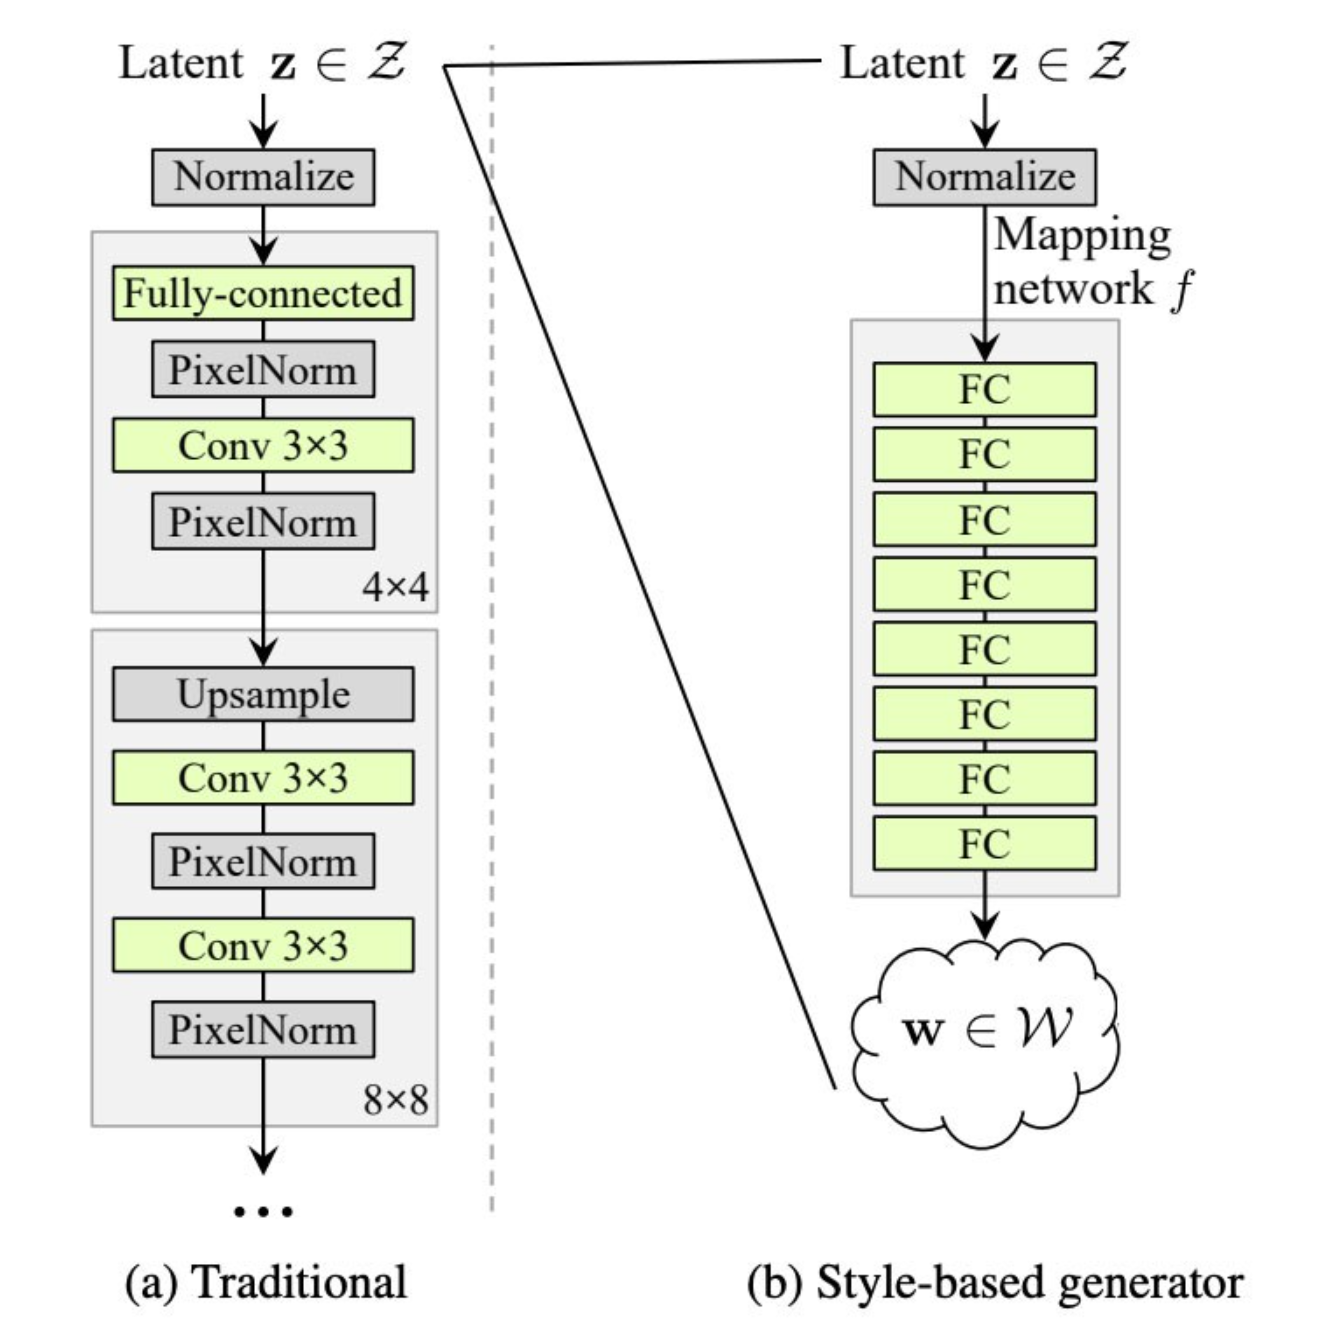

In [ ]:
class MappingNetwork(nn.Module):
    """
    Преобразует латентный вектор z в вектор стиля w.
    """
    def __init__(self, z_dim: int, hidden_dim: int, w_dim: int):
        super().__init__()
        layers = []
        for _ in range(2):
            layers.append(nn.Linear(z_dim if not layers else hidden_dim, hidden_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        layers.append(nn.Linear(hidden_dim, w_dim))
        self.mapping = nn.Sequential(*layers)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.mapping(z)

Truncation Trick

- `get_truncated_noise`: вместо генерации z из стандартного гауссовского шума, мы **ограничиваем** его (обрезаем "хвосты"). Это делает образы более опрятными и предсказуемыми.
- `scale_w`: функция, которая регулирует **насколько сильно** w отклоняется от среднего. Это даёт нам контроль: больше похожести на средний стиль = меньше артефактов.


In [ ]:
def get_truncated_noise(n: int, z_dim: int, trunc: float) -> torch.Tensor:
    """Генерирует z из усечённого нормального распределения."""
    vals = truncnorm.rvs(-trunc, trunc, size=(n, z_dim))
    return torch.tensor(vals, dtype=torch.float32)


def scale_w(w: torch.Tensor, w_avg: torch.Tensor = None, psi: float = None) -> torch.Tensor:
    """Интерполирует между w и средним для снижения артефактов."""
    if w_avg is not None and psi is not None:
        return w_avg + psi * (w - w_avg)
    return w


Мир неидеален, и чтобы научить нейросеть создавать **естественные текстуры**, мы добавляем шум в каждый слой. Это имитирует случайные вариации (например, разные волосы, складки, блики).

`InjectNoise` добавляет случайный шум в каждое изображение, но при этом масштаб шума тоже обучается!


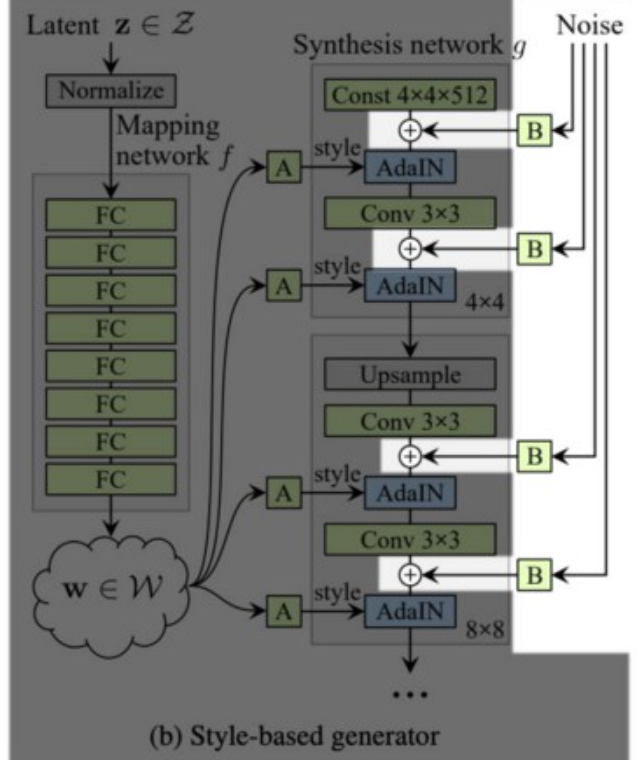

In [ ]:
class InjectNoise(nn.Module):
    """
    Добавляет шум в каждый канал признаков.
    """
    def __init__(self, channels: int):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        noise = torch.randn(x.shape[0], 1, x.shape[2], x.shape[3], device=x.device)
        return x + self.weight * noise

Основная из идей StyleGAN `AdaIN`: у нас есть нормализованное изображение (без цвета, только структура). А потом мы с помощью стиля (вектора w) говорим: "Окей, теперь придай этому содержанию характер".

- `scale` — делает изображение ярче/контрастнее.
- `shift` — двигает цвета, текстуры.

Это как если бы у вас был набросок (структура), и вы дали его разным художникам (разный стиль) — каждый из них раскрасит по-своему.

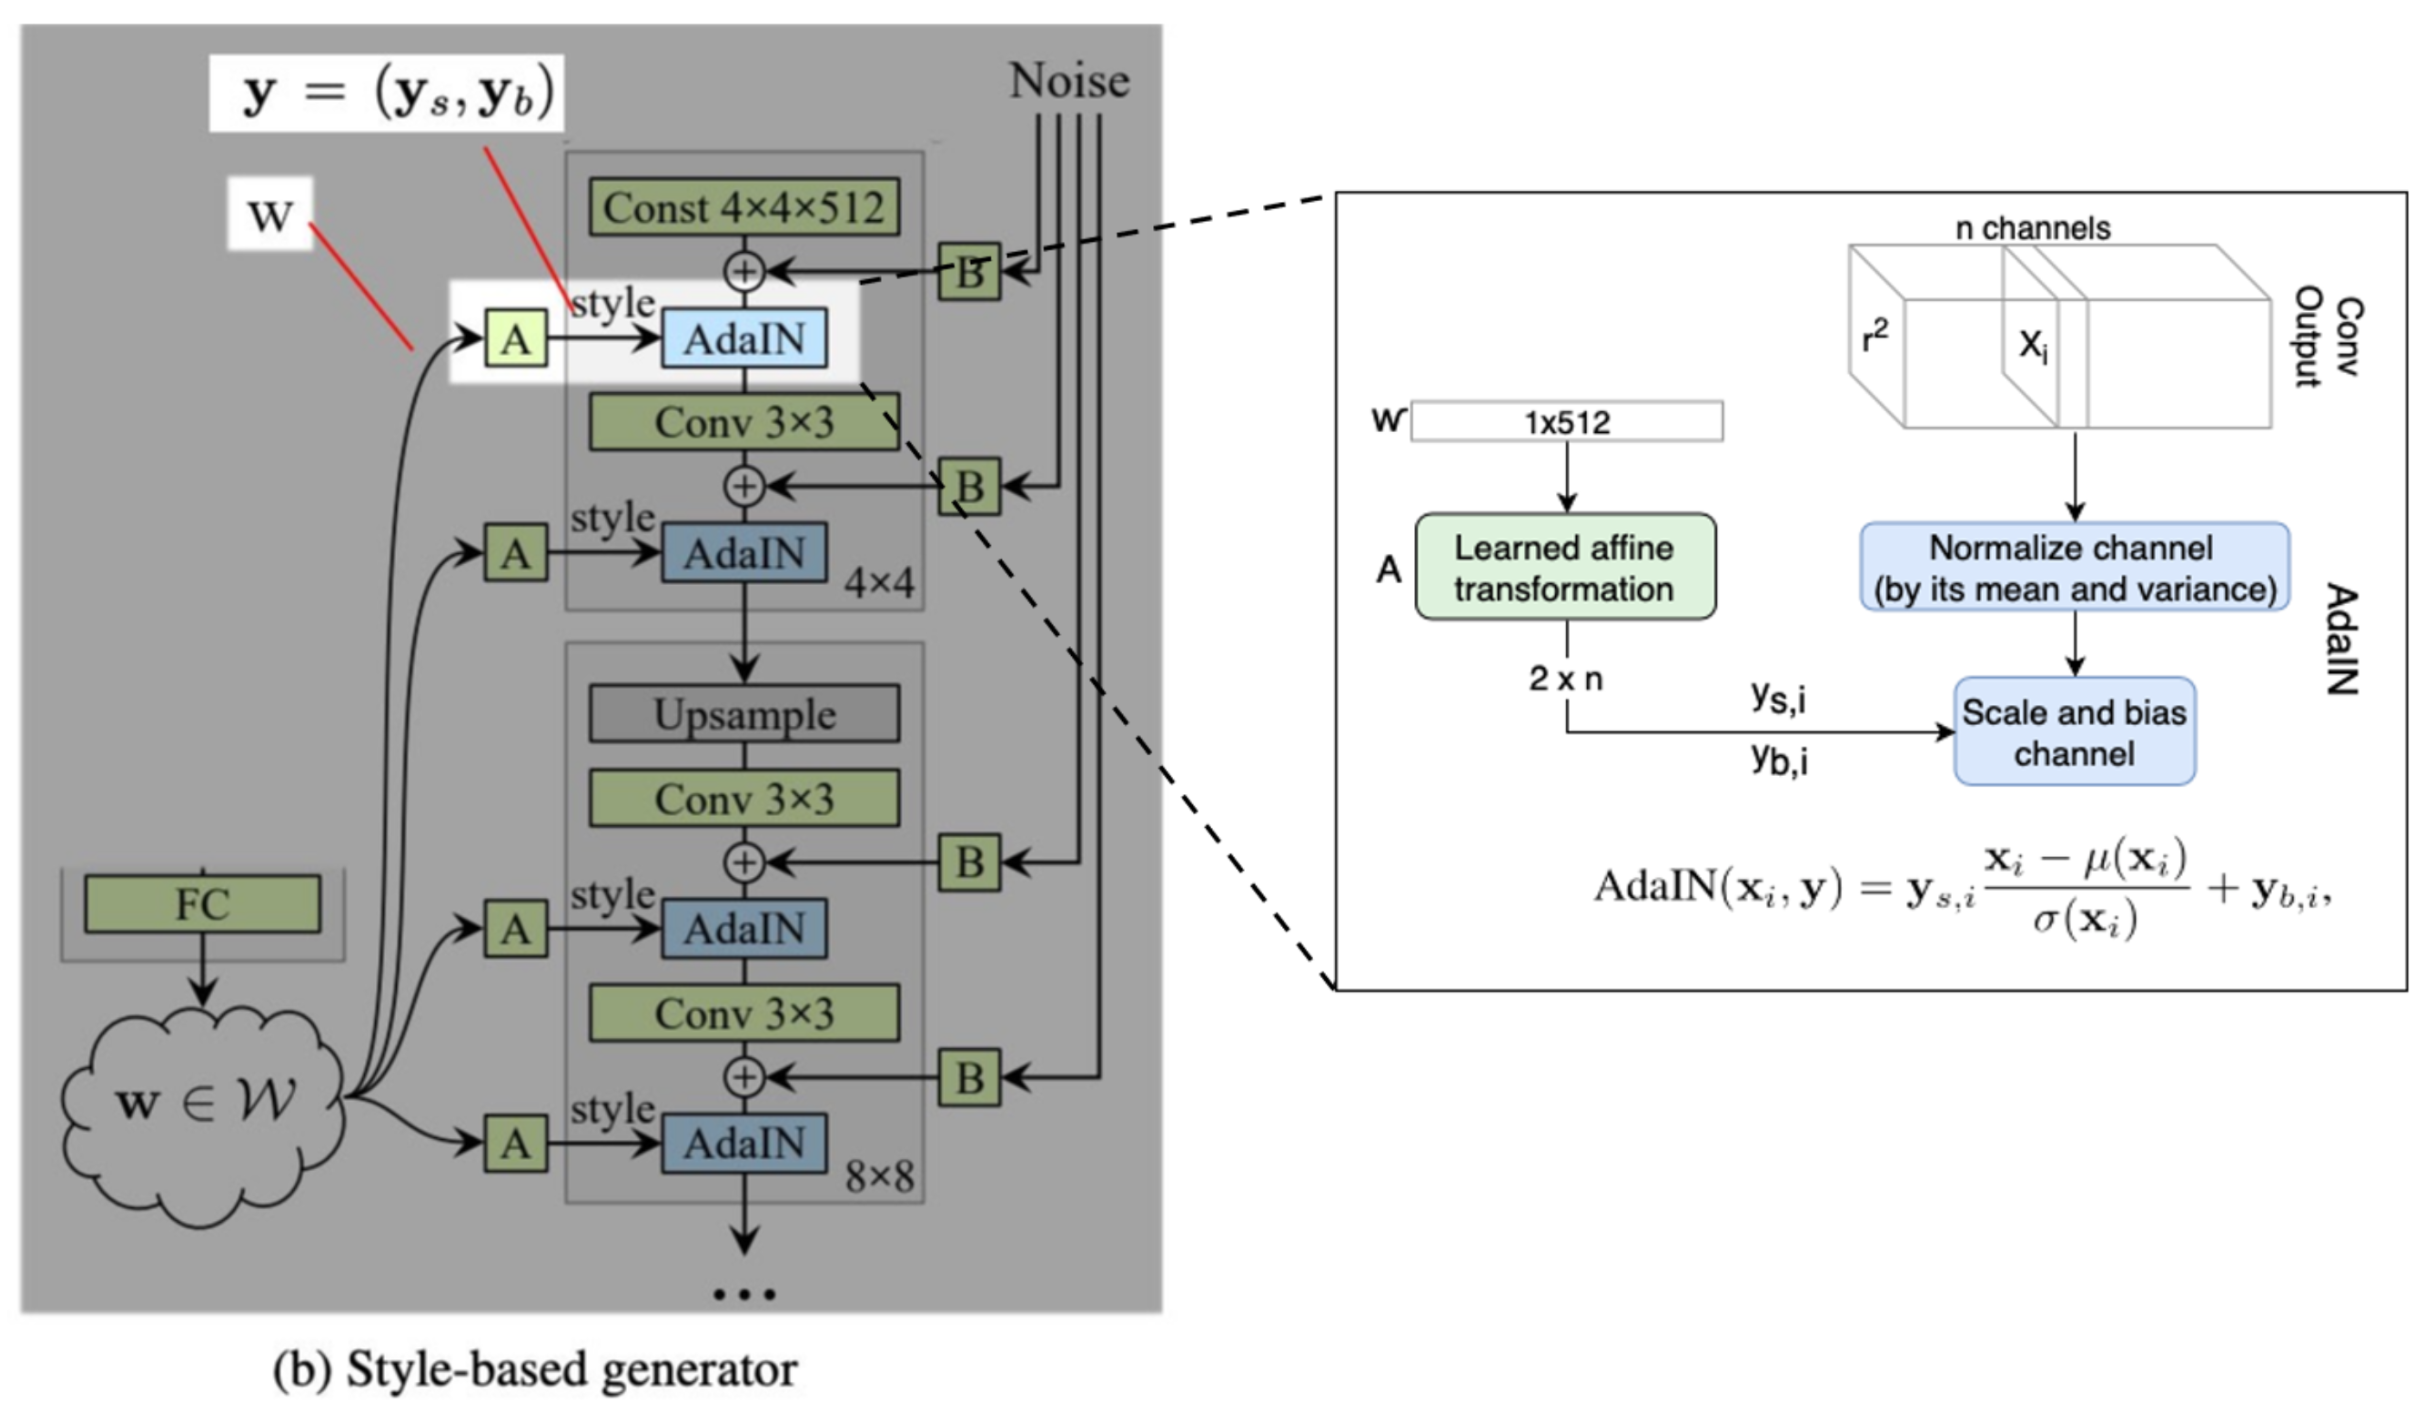

In [ ]:
class AdaIN(nn.Module):
    """
    Adaptive Instance Normalization для управления стилем.
    """
    def __init__(self, channels: int, w_dim: int):
        super().__init__()
        self.norm = nn.InstanceNorm2d(channels)
        self.scale = nn.Linear(w_dim, channels)
        self.shift = nn.Linear(w_dim, channels)

    def forward(self, x: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        x_norm = self.norm(x)
        s = self.scale(w).view(-1, x.shape[1], 1, 1)
        b = self.shift(w).view(-1, x.shape[1], 1, 1)
        return s * x_norm + b

In [ ]:
class StyleGANGenBlock(nn.Module):
    """
    Одна ступень генератора: развёртка, свёртка, шум, активация, AdaIN.
    """
    def __init__(self, in_ch, out_ch, w_dim, upsample: bool):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) if upsample else None
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.noise = InjectNoise(out_ch)
        self.act = nn.LeakyReLU(0.2)
        self.adain = AdaIN(out_ch, w_dim)

    def forward(self, x: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        if self.upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.noise(x)
        x = self.act(x)
        return self.adain(x, w)

Что такое Progressive Growing в StyleGAN?

**Проблема:**
Обучать GAN, сразу создающий большие изображения (например, 32×32, 128×128 или больше) — **сложно**. Сеть может сходиться плохо или учиться на шуме.

**Идея:**
Сначала обучаем сеть **на маленьких картинках (4×4)** — легко, быстро, сеть учится базовой структуре.

Затем **постепенно увеличиваем разрешение**:
- 8×8
- 16×16
- 32×32  
и т.д.

Каждое увеличение сопровождается **плавным переходом** (параметр `alpha`), чтобы сеть не «пугалась» нового размера и не теряла устойчивость.

---

**Параметр `step`**
Он определяет **текущий уровень разрешения**:
- `step=0`: 4×4
- `step=1`: 8×8
- `step=2`: 16×16
- `step=3`: 32×32

Именно так работает наш генератор — блоки накапливаются от низких к высоким.

---

**Параметр `alpha`**
Когда мы переключаемся с одного `step` на следующий, `alpha` помогает сделать **плавный переход**:
- `alpha = 0.0`: изображение почти полностью из старого блока
- `alpha = 1.0`: изображение полностью из нового разрешения

В промежутке мы делаем линейную интерполяцию (`img = (1-alpha)*prev + alpha*new`), это помогает избежать резких скачков и коллапса обучения.

---

**Интуиция**: сеть сначала учится рисовать «большую кляксу», затем добавляет детали — форму, текстуру, свет, стиль.



In [ ]:
class StyleGANGenerator(L.LightningModule):
    """
    Генератор StyleGAN без оптимизаторов, только forward и sample.
    """
    def __init__(self, z_dim, map_dim, w_dim, base_ch):
        super().__init__(); self.save_hyperparameters()
        self.prior = torch.distributions.Normal(0, 1)
        self.map_net = MappingNetwork(z_dim, map_dim, w_dim)
        self.const = nn.Parameter(torch.randn(1, base_ch, 4, 4))
        self.blocks = nn.ModuleList([
            StyleGANGenBlock(base_ch, base_ch, w_dim, False),
            StyleGANGenBlock(base_ch, base_ch, w_dim, True),
            StyleGANGenBlock(base_ch, base_ch, w_dim, True),
            StyleGANGenBlock(base_ch, base_ch, w_dim, True)
        ])
        self.to_rgb = nn.ModuleList([nn.Conv2d(base_ch, 3, 1) for _ in self.blocks])

    def forward(self, z, step=0, alpha=1.0, w_avg=None, psi=None):
      """
      StyleGAN forward pass with progressive growing and alpha blending.

      Parameters:
          z (Tensor): Noise vector of shape (batch, z_dim)
          step (int): Progressive step (0-3 for CIFAR-10)
          alpha (float): Fade-in parameter between resolutions
          w_avg (Tensor): Optional truncation mean
          psi (float): Optional truncation scale
      """
      w = self.map_net(z)
      w = scale_w(w, w_avg, psi)

      # Start from learned constant
      x = self.const.repeat(z.size(0), 1, 1, 1)

      for i, blk in enumerate(self.blocks[:step + 1]):
          if i > 0 and step > 0:
              x_prev = x
          x = blk(x, w)

      img = self.to_rgb[step](x)

      # Fade in previous resolution image if alpha < 1
      if step > 0 and 0 <= alpha < 1:
          skip_rgb = self.to_rgb[step - 1](x_prev)
          skip_rgb = F.interpolate(skip_rgb, scale_factor=2, mode='bilinear', align_corners=False)
          img = (1 - alpha) * skip_rgb + alpha * img

      return torch.tanh(img)

    def sample(self, n_or_z, step=0, alpha=1.0, w_avg=None, psi=None):
        if isinstance(n_or_z, int):
            z = self.prior.sample((n_or_z, self.hparams.z_dim)).to(self.device)
        else:
            z = n_or_z
        return self.forward(z, step, alpha, w_avg, psi)

In [ ]:
class StyledSequential(nn.Sequential):
    """
    Последовательный вызов модулей, принимающих аргументы x, w.
    """
    def forward(self, x, w):
        for module in self._modules.values():
            x = module(x, w)
        return x

In [ ]:
class ConvBlock(nn.Module):
    """
    Базовый свёрточный блок дискриминатора: две свёртки с LeakyReLU и опциональным даунсемплингом.
    """
    def __init__(self, in_channel: int, out_channel: int, kernel_size: int, downsample: bool = False):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, padding=kernel_size//2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        if downsample:
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size, padding=kernel_size//2),
                nn.AvgPool2d(2),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size, padding=kernel_size//2),
                nn.LeakyReLU(0.2, inplace=True)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [ ]:
class StyleGANDiscriminator(L.LightningModule):
    def __init__(self, in_chan, out_chan, kernel_size, hidden_ch):
        super().__init__(); self.save_hyperparameters()
        self.from_rgb = nn.ModuleList([nn.Conv2d(out_chan, hidden_ch, 1) for _ in range(4)])
        self.progression = nn.ModuleList([
            ConvBlock(hidden_ch, hidden_ch, kernel_size, True),
            ConvBlock(hidden_ch, hidden_ch, kernel_size, True),
            ConvBlock(hidden_ch, hidden_ch, kernel_size, True),
            nn.Sequential(
                nn.Conv2d(hidden_ch, hidden_ch, kernel_size, padding=kernel_size//2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(hidden_ch, hidden_ch, 4),  # всегда hidden_ch -> 1x1
                nn.LeakyReLU(0.2, inplace=True)
            )
        ])
        # Линейный классификатор на hidden_ch признаков
        self.linear = nn.Linear(hidden_ch, 1)

    def forward(self, img, step=0, alpha=1.0):
        # Определяем, какой уровень прогрессии использовать
        idx = 3 - step
        # Сначала конвертируем RGB в фичи
        x = self.from_rgb[idx](img)
        # Прогоняем через текущий блок
        x = self.progression[idx](x)
        # Skip-смешивание при плавном переходе (blend)
        if step > 0 and 0 <= alpha < 1:
            skip = self.from_rgb[idx + 1](F.avg_pool2d(img, 2))
            x = alpha * x + (1 - alpha) * skip
        # Допрогоняем по предыдущим блокам (только если step>0)
        if step > 0:
            for i in range(step - 1, -1, -1):
                ind = 3 - i
                x = self.progression[ind](x)
        # Глобальный средний пул и линейная классификация
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        # TODO: реализовать loss дискриминатора и логирование
        pass

In [ ]:
z_dim, out_ch, trunc = 128, 3, 0.7
G = StyleGANGenerator(z_dim,256,64,64)
D = StyleGANDiscriminator(64,out_ch,3,32)
noise = get_truncated_noise(10, z_dim, trunc)
img = G(noise,step=2,alpha=0.5)
assert img.shape == (10,out_ch,16,16)
out = D(img,step=2,alpha=0.5)
assert out.shape == (10,1)
print("Unit tests passed")

In [ ]:
# Загружаем CIFAR10 через torchvision
transform = transforms.Compose([
    transforms.ToTensor(),  # из [0,255] в [0,1]
    transforms.Lambda(lambda x: (x - 0.5) / 0.5)  # в [-1,1]
])
train_dataset_raw = CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset_raw = CIFAR10(root="./data", train=False, download=True, transform=transform)

# Вспомогательный класс для мультиразрешений
class MultiResCIFAR10Dataset(Dataset):
    res2avgpoolops = {32:0,16:1,8:2,4:3,2:4}

    def __init__(self, dataset, resolution=32):
        super().__init__()
        # dataset: torchvision Dataset, отдаёт тензоры (C,H,W)
        self.init_data = [dataset[i][0].numpy() for i in range(len(dataset))]
        self.data = {}
        self.resolution = resolution

    @property
    def resolution(self): return self._resolution

    @resolution.setter
    def resolution(self, val):
        assert val in [2,4,8,16,32]
        self._resolution = val
        ops = self.res2avgpoolops[val]
        if val not in self.data:
            pooled = []
            for x in self.init_data:
                img = x
                # применяем block_reduce ops раз
                for _ in range(ops):
                    img = skimage.measure.block_reduce(img, (1,2,2), np.mean)
                pooled.append(img)
            arr = np.stack(pooled)
            self.data[val] = torch.from_numpy(arr).float()

    def __len__(self): return len(self.init_data)
    def __getitem__(self, idx): return self.data[self.resolution][idx]

# Создадим датасет и даталоадеры для прогрессивного обучения
multi_train = MultiResCIFAR10Dataset(train_dataset_raw, resolution=32)
for res in [32,16,8,4]:
    multi_train.resolution = res
    loader = DataLoader(multi_train, batch_size=8, shuffle=True)
    batch = next(iter(loader))  # тензор формы (B, C, res, res)
    print(f"Batch at {res}x{res}:", batch.shape)
    show_tensor_images(batch, num_images=8, nrow=8)

In [ ]:
class AlphaScheduler:
    """
    Базовый интерфейс шедулера для коэффициента alpha.
    """
    def __call__(self, iteration: int) -> float:
        raise NotImplementedError()

class ConstantAlphaScheduler(AlphaScheduler):
    """
    Всегда возвращает фиксированное значение alpha.
    """
    def __init__(self, alpha: float = 1.0):
        self.alpha = float(alpha)
    def __call__(self, iteration: int) -> float:
        return self.alpha

class LinearProgressiveAlphaScheduler(AlphaScheduler):
    """
    Постепенно увеличивает alpha от 0 до 1 за warmup_iters итераций.
    """
    def __init__(self, warmup_iters: int):
        assert warmup_iters >= 1
        self.warmup_iters = warmup_iters
    def __call__(self, iteration: int) -> float:
        return min(iteration / float(self.warmup_iters), 1.0)

class ImagesManager(Callback):
    """
    Callback для логирования сэмплов генератора в TensorBoard каждую эпоху.
    Сохраняет снимки в self.stats для последующего анализа.
    """
    def __init__(self, fixed_z: torch.Tensor, num_samples: int = 8, seed: int = 0):
        super().__init__()
        self.fixed_z = fixed_z
        self.num_samples = num_samples
        self.seed = seed
        self.stats = defaultdict(lambda: defaultdict(list))

    def on_train_epoch_end(self, trainer, pl_module):
        # Фиксируем сид для воспроизводимости образцов
        torch.manual_seed(self.seed)
        alpha = pl_module.current_alpha
        step = pl_module.current_step_level
        z = self.fixed_z.to(pl_module.device)
        imgs = pl_module(z, step=step, alpha=alpha)
        arr = imgs.detach().cpu().numpy()
        res = arr.shape[-1]
        epoch = trainer.current_epoch
        self.stats[res][epoch].append(arr)
        # Логирование первых num_samples изображений
        grid = torchvision.utils.make_grid(
            imgs[:self.num_samples],
            nrow=int(np.sqrt(self.num_samples)),
            normalize=True,
            value_range=(-1, 1)
        )
        trainer.logger.experiment.add_image(f"samples_{res}x{res}", grid, epoch)

In [ ]:
class GANLightningModule(LightningModule):
    """
    StyleGAN GAN c R1 регуляризацией и поддержкой прогрессивного alpha.
    Обучение дискриминатора и генератора ручным способом.
    """
    def __init__(
        self,
        generator: LightningModule,
        discriminator: LightningModule,
        z_dim: int,
        alpha_scheduler: AlphaScheduler,
        critic_steps: int = 1,
        gp_weight: float = 10.0,
        lr_g: float = 1e-4,
        lr_d: float = 1e-4
    ):
        super().__init__()
        self.automatic_optimization = False  # ручная оптимизация
        self.save_hyperparameters(ignore=['generator','discriminator'])
        self.generator = generator
        self.discriminator = discriminator
        self.prior = torch.distributions.Normal(0, 1)
        self.current_step_level = 0
        self.current_alpha = 1.0

    def forward(self, z, step, alpha, w_avg=None, psi=None):
        return self.generator.sample(z, step=step, alpha=alpha, w_avg=w_avg, psi=psi)

    def gradient_penalty(self, real_imgs, real_scores):
        grads = grad(outputs=real_scores.sum(), inputs=real_imgs, create_graph=True)[0]
        return grads.view(grads.size(0), -1).norm(2, dim=1).pow(2).mean()

    def configure_optimizers(self):
        opt_d = optim.Adam(self.discriminator.parameters(), lr=self.hparams.lr_d, betas=(0., 0.9))
        opt_g = optim.Adam(self.generator.parameters(),   lr=self.hparams.lr_g, betas=(0., 0.9))
        return [opt_d, opt_g]

    def training_step(self, batch, batch_idx):
        opt_d, opt_g = self.optimizers()
        real_imgs = batch.to(self.device)
        bs = real_imgs.size(0)
        iteration = self.global_step
        alpha = self.hparams.alpha_scheduler(iteration)
        step = self.current_step_level
        self.current_alpha = alpha

        # --- Обновление дискриминатора ---
        opt_d.zero_grad()
        real_imgs.requires_grad_(True)
        real_scores = self.discriminator(real_imgs, step=step, alpha=alpha)
        real_loss = F.softplus(-real_scores).mean()
        gp = self.gradient_penalty(real_imgs, real_scores)
        z = self.prior.sample((bs, self.hparams.z_dim)).to(self.device)
        fake_imgs = self.generator.sample(z, step=step, alpha=alpha).detach()
        fake_scores = self.discriminator(fake_imgs, step=step, alpha=alpha)
        fake_loss = F.softplus(fake_scores).mean()
        d_loss = real_loss + fake_loss + self.hparams.gp_weight * gp
        self.manual_backward(d_loss)
        opt_d.step()
        self.log('d_loss', d_loss, prog_bar=True)
        self.log('gp', gp)
        self.log('alpha', alpha)

        # --- Обновление генератора через каждые critic_steps ---
        if (iteration % self.hparams.critic_steps) == 0:
            opt_g.zero_grad()
            z = self.prior.sample((bs, self.hparams.z_dim)).to(self.device)
            fake_imgs = self.generator.sample(z, step=step, alpha=alpha)
            fake_scores = self.discriminator(fake_imgs, step=step, alpha=alpha)
            g_loss = F.softplus(-fake_scores).mean()
            self.manual_backward(g_loss)
            opt_g.step()
            self.log('g_loss', g_loss, prog_bar=True)

In [ ]:
gan_module = GANLightningModule(
    generator=StyleGANGenerator(z_dim=128, map_dim=256, w_dim=64, base_ch=64),
    discriminator=StyleGANDiscriminator(in_chan=64, out_chan=3, kernel_size=3, hidden_ch=32),
    z_dim=128,
    alpha_scheduler=ConstantAlphaScheduler(1.0),
    critic_steps=1,
    gp_weight=1.0,
    lr_g=1e-3,
    lr_d=1e-3
)

In [ ]:
# Параметры по шагам прогрессии
VARY_PROGRESSIVE_PARAMS = {
    0: {'max_epochs': 10, 'alpha_scheduler': ConstantAlphaScheduler(1.0)},
    1: {'max_epochs': 10, 'alpha_scheduler': LinearProgressiveAlphaScheduler(2000)},
    2: {'max_epochs': 10, 'alpha_scheduler': LinearProgressiveAlphaScheduler(2000)},
    3: {'max_epochs': 10, 'alpha_scheduler': LinearProgressiveAlphaScheduler(2000)},
}

# Checkpoint и изображений колбэки
checkpoint = ModelCheckpoint(monitor='g_loss', mode='min')
fixed_z = torch.randn(16, gan_module.hparams.z_dim)
img_callback = ImagesManager(fixed_z, num_samples=16)

# Запуск по шагам
step2res = {0:4, 1:8, 2:16, 3:32}
for step in range(4):
    params = VARY_PROGRESSIVE_PARAMS[step]
    print(f"Training at resolution {step2res[step]}x{step2res[step]}")
    # обновляем alpha_scheduler и уровни в модуле
    gan_module.hparams.alpha_scheduler = params['alpha_scheduler']
    gan_module.current_step_level = step

    # DataLoader на текущее разрешение
    multi_train.resolution = step2res[step]
    loader = DataLoader(multi_train, batch_size=64, shuffle=True, num_workers=4)

    # Настройка Trainer
    trainer = Trainer(
        max_epochs=params['max_epochs'],
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1 if torch.cuda.is_available() else None,
        callbacks=[img_callback, checkpoint],
        log_every_n_steps=100,
    )

    # Обучение
    t0 = time.time()
    trainer.fit(gan_module, loader)
    print(f"Step {step} done in {time.time()-t0:.1f}s")

    # Сэмплы на данном разрешении:
    samples = gan_module.generator.sample(fixed_z, step=step, alpha=1.0).detach().cpu()
    batch = denormalize_image(samples)  # numpy array in [0,1]
    show_tensor_images(batch, num_images=batch.shape[0], nrow=8)

In [ ]:
for res in img_callback.stats:
    for epoch in sorted(img_callback.stats[res]):
        imgs_np = img_callback.stats[res][epoch][0]  # numpy array shape [B,C,H,W]
        imgs_tensor = torch.from_numpy(imgs_np).float()
        show_tensor_images(imgs_tensor, num_images=imgs_tensor.shape[0], nrow=8)


Попробуем поварьировать изображения и влиять на генерацию.
Мы возьмем два разных латентных вектора `z1` и `z2`, получим из них стили `w1` и `w2`.

- В одном случае оставим первые стили фиксированными (`w1`), а поздние заменим на `w2`.
- В другом случае наоборот — фиксируем fine, а coarse варьируем.

Ожидаем: изображение останется «в целом» похожим, но будут меняться либо крупные формы, либо текстуры.


In [ ]:
def generate_styled(model, ws):
    """
    Генерирует изображение, используя список векторов стиля ws (один на каждый блок).

    Parameters:
        model (StyleGANGenerator): обученная модель генератора
        ws (List[Tensor]): список векторов w, по одному на каждый блок

    Returns:
        Tensor: сгенерированные изображения
    """
    assert len(ws) == len(model.blocks), "Нужно подать по одному w на каждый блок"
    with torch.no_grad():
        # Начинаем с обучаемой константы, копируем её на весь батч
        x = model.const.repeat(ws[0].size(0), 1, 1, 1).to(DEVICE)

        # Применяем блоки генерации, подставляя свои стили на каждый уровень
        for conv, w in zip(model.blocks, ws):
            x = conv(x, w.to(DEVICE))

        # Преобразуем в изображение (последний уровень to_rgb)
        out = model.to_rgb[-1](x)
        return torch.tanh(out)


In [ ]:
# Переключаем генератор в eval-режим и нужное устройство
generator = gan_module.generator.to(DEVICE).eval()
# Стиль coarse по X, стиль fine по Y
z_coarse = generator.prior.sample((7, gan_module.hparams.z_dim)).to(DEVICE)
z_fine   = generator.prior.sample((7, gan_module.hparams.z_dim)).to(DEVICE)

w_coarse = generator.map_net(z_coarse)
w_fine = generator.map_net(z_fine)

all_images = []

for wf in w_fine:
    row_imgs = []
    for wc in w_coarse:
        ws = [wc.unsqueeze(0).repeat(1,1)] * 2 + [wf.unsqueeze(0).repeat(1,1)] * 2
        img = generate_styled(generator, ws)
        row_imgs.append(img)
    all_images.append(torch.cat(row_imgs, dim=0))

grid_tensor = torch.cat(all_images, dim=0)

print("🧩 Grid: X - coarse style, Y - fine style")
show_tensor_images(denormalize_image(grid_tensor), num_images=49, nrow=7)


# Бонусная часть. stylegan2-ada-pytorch песочница

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch

In [ ]:
import os
import numpy as np
import sys
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

sys.path.append("stylegan2-ada-pytorch")

import dnnlib
import legacy

torch.manual_seed(42)
np.random.seed(42)


In [ ]:
import contextlib
# Скрывает некорректную работу плагина
# Не влияет на работоспособность модели
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


In [ ]:
def load_stylegan_model(model_path):
    """
    Загружает предобученную модель StyleGAN2 из .pkl файла.

    Аргументы:
        model_path: путь к .pkl-файлу модели

    Возвращает:
        G: генератор StyleGAN2
        device: CUDA или CPU
    """
    print(f"Загрузка модели из {model_path}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with dnnlib.util.open_url(model_path) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device)
    return G, device


In [ ]:
def generate_random_face(G, device, seed=None, truncation_psi=0.7):
    """
    Генерация случайного лица из латентного вектора.

    Аргументы:
        G: генератор StyleGAN2
        device: устройство (CPU или CUDA)
        seed: сид генерации
        truncation_psi: насколько "усреднять" стиль (0.5 более реалистично)

    Возвращает:
        img: изображение лица
        z: латентный вектор
    """
    if seed is not None:
        torch.manual_seed(seed)

    z = torch.randn([1, G.z_dim], device=device)

    with torch.no_grad():
        img = G(z, None, truncation_psi=truncation_psi, noise_mode='const')

    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    return img[0].cpu().numpy(), z


In [ ]:
def interpolate_latent_vectors(z1, z2, num_steps=10):
    """
    Линейная интерполяция между двумя латентными векторами.
    """
    return [(1 - t) * z1 + t * z2 for t in np.linspace(0, 1, num_steps)]


In [ ]:
def generate_interpolation_frames(G, z1, z2, device, num_steps=10, truncation_psi=0.7):
    """
    Создаёт список изображений — плавный переход между двумя лицами.
    """
    images = []
    interpolated_z = interpolate_latent_vectors(z1, z2, num_steps)

    with torch.no_grad():
        for z in tqdm(interpolated_z):
            img = G(z, None, truncation_psi=truncation_psi, noise_mode='const')
            img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
            images.append(img[0].cpu().numpy())
    return images


In [ ]:
def visualize_interpolation(images, title="Face Interpolation"):
    """
    Показывает последовательность изображений в одной строке.
    """
    plt.figure(figsize=(len(images)*3, 3))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title("Start")
        elif i == len(images)-1:
            plt.title("End")
        elif i == len(images)//2:
            plt.title("Middle")
        else:
            plt.title(f"Step {i}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [ ]:
def create_interpolation_animation(images, output_path="interpolation.gif", duration=100):
    """
    Создание .gif из последовательности изображений.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.axis('off')

    def update(i):
        ax.clear()
        ax.imshow(images[i])
        ax.axis('off')
        return [ax]

    ani = FuncAnimation(fig, update, frames=len(images), blit=True)
    ani.save(output_path, writer='pillow', fps=1000/duration)
    plt.close()
    print(f"✅ Анимация сохранена в {output_path}")


In [ ]:
def save_images(images, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i, img in enumerate(images):
        Image.fromarray(img).save(os.path.join(output_dir, f"interp_{i:02d}.png"))


In [ ]:
model_path = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
G, device = load_stylegan_model(model_path)


In [ ]:
# 🎩 Генерация двух лиц
with suppress_output():
  male_img, male_z = generate_random_face(G, device, seed=62)
  female_img, female_z = generate_random_face(G, device, seed=42)

# 💾 Сохраняем начальные изображения
Image.fromarray(male_img).save(os.path.join(output_dir, "male.png"))
Image.fromarray(female_img).save(os.path.join(output_dir, "female.png"))


In [ ]:
with suppress_output():
  num_steps = 10
  interpolated_images = generate_interpolation_frames(G, male_z, female_z, device, num_steps)
  save_images(interpolated_images, output_dir)
  visualize_interpolation(interpolated_images)
  create_interpolation_animation(interpolated_images, os.path.join(output_dir, "interpolation.gif"))


In [ ]:
def generate_child_with_future_appearance(G, child_seed=0, adult_seed=42, output_dir="child_future"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(output_dir, exist_ok=True)

    torch.manual_seed(child_seed)
    z_child = torch.randn([1, G.z_dim], device=device)

    torch.manual_seed(adult_seed)
    z_adult = torch.randn([1, G.z_dim], device=device)

    with torch.no_grad():
        w_child = G.mapping(z_child, None, truncation_psi=0.7)
        w_adult = G.mapping(z_adult, None, truncation_psi=0.7)

        img_child = G.synthesis(w_child, noise_mode='const')
        img_adult = G.synthesis(w_adult, noise_mode='const')

        img_child = (img_child.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
        img_adult = (img_adult.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

    Image.fromarray(img_child).save(os.path.join(output_dir, "child_original.png"))
    Image.fromarray(img_adult).save(os.path.join(output_dir, "adult_donor.png"))

    predictions = []
    style_boundaries = [(0, 4), (0, 8), (0, 12)]

    for _, end in style_boundaries:
        w_mixed = w_child.clone()
        w_mixed[:, end:, :] = w_adult[:, end:, :]

        with torch.no_grad():
            img = G.synthesis(w_mixed, noise_mode='const')
            img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

        predictions.append(img)
        Image.fromarray(img).save(os.path.join(output_dir, f"future_prediction_layers_{end}.png"))

    # 🧒 Сравнение: ребёнок, разные стили, взрослый
    plt.figure(figsize=((len(predictions) + 2) * 4, 5))
    plt.subplot(1, len(predictions) + 2, 1)
    plt.imshow(img_child); plt.title("Child"); plt.axis('off')

    for i, img in enumerate(predictions):
        plt.subplot(1, len(predictions) + 2, i + 2)
        plt.imshow(img); plt.title(f"Styles 0–{style_boundaries[i][1]}"); plt.axis('off')

    plt.subplot(1, len(predictions) + 2, len(predictions) + 2)
    plt.imshow(img_adult); plt.title("Adult Donor"); plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "predictions_comparison.png"))
    plt.show()

    return img_child, predictions, img_adult


In [ ]:
# 🔮 Предсказание взросления
with suppress_output():
  img_child, predictions, img_adult = generate_child_with_future_appearance(G, child_seed=8, adult_seed=62)


Особенности версий StyleGAN

| Feature | StyleGAN | StyleGAN2 | StyleGAN3 |
|---------|----------|-----------|-----------|
| Main Innovation | Style-based generator with AdaIN | Redesigned normalization with weight demodulation | Alias-free design for rotation equivariance |
| Training Method | Progressive growing | Non-progressive training | Non-progressive with alias-free design |
| Key Issue Fixed | Initial style-based approach | "Droplet" artifacts | "Texture sticking" problem |
| Normalization | AdaIN (Adaptive Instance Normalization) | Weight modulation and demodulation | Weight modulation with filtered sampling |
| Feature Locality | Fixed feature positioning | Improved but with "texture sticking" | Natural feature movement with transformations |
| Latent Space | Z-space and W-space | Z-space, W-space, and W+ space | Z-space, W-space, and W+ space |